In [4]:
import numpy as np
import pymc as pm

from pyei.data import Datasets
from pyei.two_by_two import TwoByTwoEI
from pyei.goodmans_er import GoodmansER
from pyei.goodmans_er import GoodmansERBayes
from pyei.r_by_c import RowByColumnEI
from pyei.io_utils import from_netcdf, to_netcdf

/Users/mahir/416/c1/ei_test/ei_venv/lib/python3.12/site-packages/numba/core/decorators.py:248: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [ ]:
# get columns of interest

"""
Currently working on voting equipment data
F5a - DRE no VVPAT
F6a - DRE with VVPAT
F7a - Ballot Marking Device
F8a - Scanner
F9a - Punch Card
F10a - Lever

come up with a scoring system for equipment types
"""



import pandas as pd

raw_df = pd.read_csv("2020_eavs_data/eavs_2020_latest.csv", dtype=str, keep_default_na=False, na_values=[], low_memory=False)
raw_df = raw_df.query("State_Abbr == 'FL'")

raw_df.to_csv("florida_rejection_rates_raw.csv", index=False)

rename_map = {
    # metadata columns that anchor the data before totals
    "State_Abbr": "State_Abbr",
    "Jurisdiction_Name": "Jurisdiction_Name",
    "FIPSCode": "FIPSCode",

    # counted ballot totals
    "B14a": "uocava_counted_total",
    "B15a": "post_mail_counted_total",
    "B16a": "email_counted_total",
    "B17a": "other_counted_total",
    "C3a": "by_mail_counted_total",
    "B24a": "total_fwab_counted",
    "E1b": "provisional_counted_full_ballot",

    # rejected ballot totals
    "B3a": "rejected_fpca_total",
    "B18a": "uocava_rejected_total",
    "B19a": "deadline_rejected_total",
    "B20a": "signature_rejected_total",
    "B21a": "postmark_rejected_total",
    "B22a": "other_rejected_total",
    "C4a": "by_mail_rejected_total",
}

df = raw_df[list(rename_map.keys())].rename(columns=rename_map)

print(df.head())
df.to_csv("florida_rejection_rates.csv", index=False)


    State_Abbr Jurisdiction_Name    FIPSCode uocava_counted_total  \
454         FL    ALACHUA COUNTY  1200100000                 1578   
455         FL      BAKER COUNTY  1200300000                   55   
456         FL        BAY COUNTY  1200500000                 2483   
457         FL   BRADFORD COUNTY  1200700000                   77   
458         FL    BREVARD COUNTY  1200900000                 4647   

    post_mail_counted_total email_counted_total other_counted_total  \
454                    1100                   1                 477   
455                      55                   0                   0   
456                     -99                   0                 -99   
457                      73                   0                   4   
458                    4095                   0                 552   

    by_mail_counted_total total_fwab_counted provisional_counted_full_ballot  \
454                 60158                  0                              83  

In [7]:
# clean all negative values to zero, -77 is NA, -88, -99 are missing data
# rejections and counts are lower bound values

import pandas as pd

df = pd.read_csv("florida_rejection_rates.csv")

sentinel_values = [-77, -88, -99]
df.replace(sentinel_values, pd.NA, inplace=True)

numeric_cols = df.select_dtypes(include="number").columns
df[numeric_cols] = df[numeric_cols].clip(lower=0)
df[numeric_cols] = df[numeric_cols].fillna(0).astype("Int64")

df.to_csv("florida_rejection_rates.csv", index=False)




In [8]:
# get total rejections and total counts

import pandas as pd

df = pd.read_csv("florida_rejection_rates.csv")

rejection_columns = [
    "rejected_fpca_total",
    "uocava_rejected_total",
    "deadline_rejected_total",
    "signature_rejected_total",
    "postmark_rejected_total",
    "other_rejected_total",
    "by_mail_rejected_total",
]
count_columns = [
    "uocava_counted_total",
    "post_mail_counted_total",
    "email_counted_total",
    "other_counted_total",
    "by_mail_counted_total",
    "total_fwab_counted",
    "provisional_counted_full_ballot",
]

df["total_rejections"] = df[rejection_columns].sum(axis=1)
df["total_counts"] = df[count_columns].sum(axis=1)

df.to_csv("florida_rejection_rates.csv", index=False)


In [9]:
# Get columns of interest (multiple lnnumber buckets)

import pandas as pd

df = pd.read_csv("2020_cvap_data/County.csv", encoding="latin1")
df["geoid"] = df["geoid"].astype(str).str.replace(r"^0500000US", "", regex=True)
df = df[df["geoid"].str.startswith("12")].copy()

df["lnnumber"] = pd.to_numeric(df["lnnumber"], errors="coerce")
df = df[df["lnnumber"].isin([1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])]

filtered = df[["geoname", "geoid", "lnnumber", "tot_est"]].copy()
filtered = filtered.sort_values(["geoname", "lnnumber"])
filtered = filtered.rename(columns={"tot_est": "count"})

print(filtered.head())
filtered.to_csv("florida_race_counts_raw.csv", index=False)


                      geoname  geoid  lnnumber   count
4173  Alachua County, Florida  12001         1  268105
4175  Alachua County, Florida  12001         3     680
4176  Alachua County, Florida  12001         4   16200
4177  Alachua County, Florida  12001         5   53450
4178  Alachua County, Florida  12001         6     145


In [10]:
import pandas as pd

df = pd.read_csv("florida_race_counts_raw.csv")
counts = (
    df.pivot_table(
        index=["geoname", "geoid"],
        columns="lnnumber",
        values="count",
        aggfunc="sum",
    )
    .reset_index()
)

sum_cols = list(range(3, 14))  # covers 3 through 13
for col in sum_cols + [1]:
    counts[col] = pd.to_numeric(counts[col], errors="coerce").fillna(0)

counts["diff"] = counts[sum_cols].sum(axis=1) - counts[1]
mask = counts["diff"] != 0
inconsistent = counts.loc[mask, ["geoname", "geoid", "diff"]]

print("Counties where sum(lnnumbers 3–13) ≠ ln1:")
print(inconsistent.to_string(index=False))


Counties where sum(lnnumbers 3–13) ≠ ln1:
                     geoname  geoid  diff
       Baker County, Florida  12003    -5
         Bay County, Florida  12005     5
    Bradford County, Florida  12007     4
     Brevard County, Florida  12009    10
     Broward County, Florida  12011    -5
     Calhoun County, Florida  12013    -1
   Charlotte County, Florida  12015    -5
      Citrus County, Florida  12017    -6
     Collier County, Florida  12021    -5
    Columbia County, Florida  12023     5
      DeSoto County, Florida  12027    10
       Dixie County, Florida  12029     3
    Escambia County, Florida  12033    10
     Flagler County, Florida  12035     5
   Gilchrist County, Florida  12041    -2
      Glades County, Florida  12043    -1
        Gulf County, Florida  12045    -5
      Hardee County, Florida  12049    -2
      Hendry County, Florida  12051     5
    Hernando County, Florida  12053     5
Hillsborough County, Florida  12057   -10
   Lafayette County, Florida  1206

In [11]:
# Reshape the data from long to wide format
# Fix the data by recomputing ln1 as the sum of lnnumbers 3 through 13
# Issue was due to rounding errors (+-5) in the original data source

import pandas as pd

df = pd.read_csv("florida_race_counts_raw.csv")
counts = (
    df.pivot_table(
        index=["geoname", "geoid"],
        columns="lnnumber",
        values="count",
        aggfunc="sum",
    )
    .reset_index()
)

target_cols = list(range(1, 14))
for col in target_cols:
    if col in counts:
        counts[col] = pd.to_numeric(counts[col], errors="coerce").fillna(0)

sum_cols = [col for col in range(3, 14) if col in counts]
counts["ln1_recomputed"] = counts[sum_cols].sum(axis=1)
counts["new_1"] = counts["ln1_recomputed"]
counts.drop(columns=["ln1_recomputed"], inplace=True)

counts.to_csv("florida_race_totals_fixed.csv", index=False)

In [12]:
# Compute sum of lnnumbers 8 through 12

sum8_12_cols = [col for col in range(8, 13) if col in counts]
counts["sum8_12"] = counts[sum8_12_cols].sum(axis=1) if sum8_12_cols else 0
counts.drop(columns=sum8_12_cols or [], inplace=True)

counts.to_csv("florida_race_totals_fixed.csv", index=False)

In [13]:
# fix column names and save

df = pd.read_csv("florida_race_totals_fixed.csv")
df = df.rename(columns={'1': "total", '3': 'american_ind_alaska_native', '4': 'asian', '5': 'black_african_ame', '6': 'hawaiian_pacific', '7': 'white', '13': 'hispanic', 'sum8_12': 'two_or_more_races', 'new_1': 'fixed_total'})
df.to_csv("florida_race_cols_fixed.csv", index=False)

In [14]:
#compute race percentages and save

race_df = pd.read_csv("florida_race_cols_fixed.csv")
race_columns = [
    "american_ind_alaska_native",
    "asian",
    "black_african_ame",
    "hawaiian_pacific",
    "white",
    "hispanic",
    "two_or_more_races",
]
base = "fixed_total"

for col in race_columns:
    race_df[f"{col}_pct"] = race_df[col] / race_df[base]

race_df.to_csv("florida_race_data.csv", index=False)


In [15]:
# compute rejection percentage
df = pd.read_csv("florida_rejection_rates.csv")
totals = df["total_rejections"] + df["total_counts"]
safe_totals = totals.replace(0, pd.NA)

df["rejection_pct"] = df["total_rejections"] / safe_totals
df["rejection_pct"] = df["rejection_pct"].fillna(0)
df["not_rejection_pct"] = df["total_counts"] / safe_totals
df["not_rejection_pct"] = df["not_rejection_pct"].fillna(0)

df.to_csv("florida_rejection_rates.csv", index=False)



In [16]:
import pandas as pd
import numpy as np

rej_df = pd.read_csv("florida_rejection_rates.csv")
race_df = pd.read_csv("florida_race_data.csv")

rej_fractions = np.array(rej_df[["rejection_pct", "not_rejection_pct"]]).T

pct_cols = [
    "american_ind_alaska_native_pct",
    "asian_pct",
    "black_african_ame_pct",
    "hawaiian_pacific_pct",
    "white_pct",
    "hispanic_pct",
    "two_or_more_races_pct",
]

group_fractions = np.array(race_df[pct_cols]).T

county_pops = race_df["fixed_total"].to_numpy()

demographic_group_names = [
    "Native", "Asian", "Black", "PacificIslander", "White", "Hispanic", "TwoOrMoreRaces"
]
candidate_names = ["Rejected", "NotRejected"]
county_names = rej_df["Jurisdiction_Name"].to_numpy()

print(rej_fractions.shape)
print(group_fractions.shape)
print(county_pops.shape)
print(county_names.shape)


(2, 67)
(7, 67)
(67,)
(67,)


In [17]:
# Fitting a first r x c model

# Create a RowByColumnEI object
ei_rbyc = RowByColumnEI(model_name='multinomial-dirichlet-modified', pareto_shape=100, pareto_scale=100)

# Fit the model
ei_rbyc.fit(group_fractions, 
       rej_fractions, 
       county_pops, 
       demographic_group_names=demographic_group_names, 
       candidate_names=candidate_names, 
       #precinct_names=precinct_names, 
)

# Generate a simple report to summarize the results
print(ei_rbyc.summary())

Running ['Native', 'Asian', 'Black', 'PacificIslander', 'White', 'Hispanic', 'TwoOrMoreRaces'] x ['Rejected', 'NotRejected'] EI
r = 7 rows (demographic groups)
c = 2 columns (candidates or voting outcomes)
number of precincts = 67


/Users/mahir/416/c1/ei_test/ei_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Compiling.. :   0%|          | 0/2500 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2500 [00:03<?, ?it/s]





Running chain 0:   5%|▌         | 125/2500 [00:13<03:26, 11.48it/s]


Running chain 0:  10%|█         | 250/2500 [00:31<04:24,  8.52it/s]


Running chain 0:  15%|█▌        | 375/2500 [00:46<04:16,  8.28it/s]


Running chain 0:  20%|██        | 500/2500 [01:02<04:03,  8.22it/s]


Running chain 0:  25%|██▌       | 625/2500 [01:18<03:51,  8.12it/s]


Running chain 0:  30%|███       | 750/2500 [01:31<03:26,  8.46it/s]


Running chain 0:  35%|███▌      | 875/2500 [01:44<03:03,  8.84it/s]


Running chain 0:  40%|████      | 1000/2500 [01:56<02:43,  9.19it/s]


Running chain 0:  45%|████▌     | 1125/2500 [0


            Computed from the raw b_ samples by multiplying by group populations and then
            getting the proportion of the total pop
            (total pop=summed across all districts):
            The posterior mean for the district-level voting preference of
                Native for Rejected is
                0.024
                95% equal-tailed credible interval:  [0.00289559 0.06871126]
                The posterior mean for the district-level voting preference of
                Native for NotRejected is
                0.976
                95% equal-tailed credible interval:  [0.93128874 0.99710441]
                The posterior mean for the district-level voting preference of
                Asian for Rejected is
                0.019
                95% equal-tailed credible interval:  [0.00362038 0.04446421]
                The posterior mean for the district-level voting preference of
                Asian for NotRejected is
                0.981
             

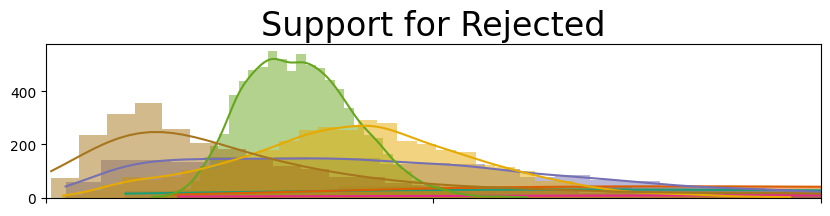

In [18]:
axes = ei_rbyc.plot_kdes()
rej_ax = [ax for ax in axes if "Rejected" in ax.get_title()][0]

rej_ax.set_xlim(0, 0.01)
rej_ax.set_xticks([0, 0.005, 0.01])
rej_ax.set_xticklabels(["0%", "0.5%", "1%"])
rej_ax.set_xlabel("Rejection Rate")

axes[1].set_visible(False)


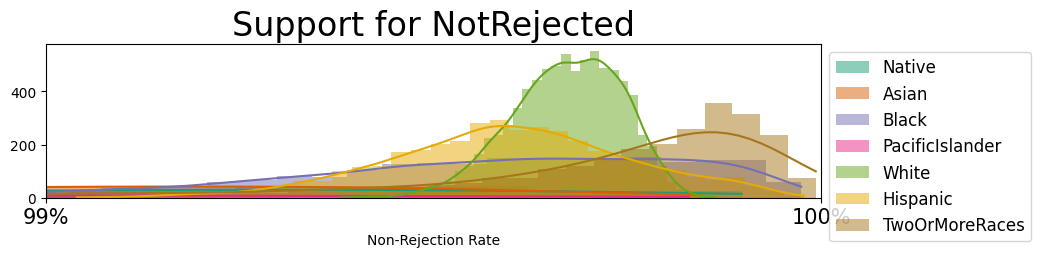

In [19]:
axes = ei_rbyc.plot_kdes()
notrej_ax = [ax for ax in axes if "NotRejected" in ax.get_title()][0]
notrej_ax.set_xlim(0.99, 1.0)
notrej_ax.set_xticks([0.99, 1.0])
notrej_ax.set_xticklabels(["99%", "100%"])
notrej_ax.set_xlabel("Non-Rejection Rate")
axes[0].set_visible(False)